<a href="https://colab.research.google.com/github/johacks/RedesNeuronales/blob/main/DQN_Cartpole.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



<p><img height="80px" src="https://www.upm.es/sfs/Rectorado/Gabinete%20del%20Rector/Logos/UPM/Escudo/EscUpm.jpg" align="left" hspace="0px" vspace="0px"></p>

**Course "Artificial Neural Networks and Deep Learning" - Universidad Politécnica de Madrid (UPM)**

# **Deep Q-Learning for Cartpole**

This notebook includes an implementation of the Deep Q-learning (DQN) algorithm for the cartpole problem (see [OpenAI's Cartpole](https://gym.openai.com/envs/CartPole-v1/)).


## Autores

Joaquín Jiménez López de Castro - jo.jimenez@alumnos.upm.es

Ángel Fragua Baeza - angel.fragua@alumnos.upm.es

Javier Solis García - javier.solis.garcia@alumnos.upm.es

# 1. Introducción

En esta práctica se ha buscado un modelo que aprenda lo antes posible a resolver el problema de Cartpole de OpenAIgym. Además de probarse distintas configuraciones de hiperparámetros, también se ha cambiado ligeramente el código original. Este notebook está dividido en las siguientes secciones:

- En el apartado 2, se muestra el código con comentarios a los cambios realizados.
- En el apartado 3, se muestra un histórico resumen de los experimentos realizados con diferentes hiperparámetros.
- En el apartado 4 se muestra el mejor modelo obtenido. 

# 2. Código

## Librerías

Se ha instalado una librería adicional para facilitar la elaboración de tablas de datos en la salida de las celdas de código.

In [2]:
!pip install texttable

In [3]:
from texttable import Texttable
import gym
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
import time
import random

## Hiperparámetros

Se han añadido algunos hiperparámetros adicionales para ajustarse a los cambios realizados en el código:

- __K_TMODEL__: Como se ha añadido una implementación con target network, se ha incorporado este hiperparámetro que indica cada cuántos steps en el proceso de aprendizaje se actualiza la target network.
- __N__: Cuántos episodios seguidos se tiene que alcanzar __MAX_STEPS__ para determinar que se ha tenido una ejecución exitosa. Esto permite medir la robustez del aprendizaje realizado.

In [4]:
# Parámetros por defecto

GAMMA = 0.99
BATCH_SIZE = 32
LEARNING_RATE = 0.001
EXPLORATION_MAX = 1
EXPLORATION_MIN = 0.01
EXPLORATION_DECAY = 0.995

MEMORY_SIZE = 100000
NUMBER_OF_EPISODES = 300
MAX_STEPS = 200
K_TMODEL = 10
N = 1

## Clase ReplayMemory

Esta clase se ha cambiado ligeramente para controlar el overflow de la memoria, haciendo que cuando la memoria esté llena se vuelva a sobrescribir desde el inicio. Sin embargo, se debería seguir intentando no llenar la memoria.

In [5]:
class ReplayMemory:

  def __init__(self,number_of_observations):
    # Create replay memory
    self.states = np.zeros((MEMORY_SIZE, number_of_observations))
    self.states_next = np.zeros((MEMORY_SIZE, number_of_observations))
    self.actions = np.zeros(MEMORY_SIZE, dtype=np.int32)
    self.rewards = np.zeros(MEMORY_SIZE)
    self.terminal_states = np.zeros(MEMORY_SIZE, dtype=bool)
    self.current_size=0

  def store_transition(self, state, action, reward, state_next, terminal_state):
    # Store a transition (s,a,r,s') in the replay memory
    i = self.current_size % MEMORY_SIZE  # .NEW
    self.states[i] = state
    self.states_next[i] = state_next
    self.actions[i] = action
    self.rewards[i] = reward
    self.terminal_states[i] = terminal_state
    self.current_size = i + 1

  def sample_memory(self, batch_size):
    # Generate a sample of transitions from the replay memory
    batch = np.random.choice(self.current_size, batch_size)
    states = self.states[batch]
    states_next = self.states_next[batch]
    rewards = self.rewards[batch]
    actions = self.actions[batch]   
    terminal_states = self.terminal_states[batch]  
    return states, actions, rewards, states_next, terminal_states

## Clase DQN, DQNTNetwork

Se ha modificado la clase base DQN para que utilize una variable target network para predecir los estados siguientes, aunque en el caso de esta clase básica, esta variable hace referencia al modelo, de manera que se tiene el mismo funcionamiento que si se tuviera una implementación sin target network. De esta forma, se pueden realizar experimentos con y sin target network cambiando solamente la clase.

También se ha implementado la clase DQNTNetwork que hereda DQN, pero hace que la variable para la target network sea independiente del modelo. También se asegura que cuando se llega a un valor determinado de steps, se actualizan los pesos de la target network con los del modelo.

In [6]:
class DQN:

  def __init__(self, number_of_observations, number_of_actions, model):
    # Initialize variables and create neural model
    self.exploration_rate = EXPLORATION_MAX
    self.number_of_actions = number_of_actions
    self.number_of_observations = number_of_observations
    self.scores = []
    self.memory = ReplayMemory(number_of_observations)
    self.model = model
    self.target_model = model

  def remember(self, state, action, reward, next_state, terminal_state):
    # Store a tuple (s, a, r, s') for experience replay
    state = np.reshape(state, [1, self.number_of_observations])
    next_state = np.reshape(next_state, [1, self.number_of_observations])
    self.memory.store_transition(state, action, reward, next_state, terminal_state)

  def select(self, state):
    # Generate an action for a given state using epsilon-greedy policy
    if np.random.rand() < self.exploration_rate:
      return random.randrange(self.number_of_actions)
    else:
      state = np.reshape(state, [1, self.number_of_observations])
      q_values = self.model.predict(state)
      return np.argmax(q_values[0])

  def learn(self, steps=None):
    # Learn the value Q using a sample of examples from the replay memory
    if self.memory.current_size < BATCH_SIZE: return

    states, actions, rewards, next_states, terminal_states = self.memory.sample_memory(BATCH_SIZE)

    q_targets = self.model.predict(states)
    q_next_states = self.target_model.predict(next_states)

    for i in range(BATCH_SIZE):
       if (terminal_states[i]):
          q_targets[i][actions[i]] = rewards[i]
       else:
          q_targets[i][actions[i]] = rewards[i] + GAMMA * np.max(q_next_states[i])  

    self.model.train_on_batch(states, q_targets)

    # Decrease exploration rate
    self.exploration_rate *= EXPLORATION_DECAY
    self.exploration_rate = max(EXPLORATION_MIN, self.exploration_rate)

  def add_score(self, score):
     # Add the obtained score in a list to be presented later
    self.scores.append(score)

  def display_scores_graphically(self):
    # Display the obtained scores graphically
    plt.plot(self.scores)
    plt.xlabel("Episode")
    plt.ylabel("Score")      

In [7]:
# .NEW
class DQNTNetwork(DQN):
  def __init__(self, number_of_observations, number_of_actions, model):
    super().__init__(number_of_observations, number_of_actions, model)
    self.target_model = keras.models.clone_model(self.model)
    self.update_target_network()

  def update_target_network(self):
    self.target_model.set_weights(self.model.get_weights())

  def learn(self, steps):
    super().learn()
    if steps % K_TMODEL:
      self.update_target_network()

## Environment Cartpole

Cartpole simulator from [Open Ai Gym](https://gym.openai.com/envs/CartPole-v1/):

<p><img height="200px" src="https://raw.githubusercontent.com/martin-molina/reinforcement_learning/main/images/cartpole_attributes.png" align="center" vspace="20px"</p>

State vector:
- state[0]: position
- state[1]: velocity
- state[2]: angle
- state[3]: angular velocity

Actions:
- 0 (push cart to the left)
- 1 (push cart to the right)

### Funciones auxiliares

Como se han estado realizando varios experimentos, se ha metido en distintas funciones algunas de las funcionalidades comunes a todos ellos.

- print_results: Mostrar los resultados e hiperparámetros de un experimento.
- episode_summary: Mostrar los resultados de un episodio.
- run: dado un agente y un entorno, lanzar un experimento. El experimento finaliza cuando se alcanza N veces seguidas el valor MAX_STEPS o se llega al número máximo de episodes NUMBER_OF_EPISODES. Como comentario adicional, se ha configurado el experimento para que se actualicen los pesos de la target network también cuando finaliza el episodio.

In [8]:
def create_environment():
  # Create simulated environment
  environment = gym.make("CartPole-v1")
  number_of_observations = environment.observation_space.shape[0]
  number_of_actions = environment.action_space.n
  return environment, number_of_observations, number_of_actions

# .NEW
def print_results(goal_reached, start_time, agent):
  if goal_reached: print("Reached goal sucessfully.")
  else: print("Failure to reach the goal.")

  print("Time:", round((time.perf_counter() - start_time)/60), "minutes")
  agent.display_scores_graphically()
  table = Texttable(max_width=120)
  table.set_deco(Texttable.HEADER)
  table.set_cols_dtype(['f', 'i', 'f', 'i', 'i', 'f', 'f', 'i', 'i', 'i'])
  table.set_cols_align(["c"]*10)
  table.add_rows([["𝛾", "Memory size", "α", "Batch size", "Exploration max", "Exploration min", "Exploration decay", "Nº episodes", "Max steps", "k"],
                  [GAMMA, MEMORY_SIZE, LEARNING_RATE, BATCH_SIZE, EXPLORATION_MAX, EXPLORATION_MIN, EXPLORATION_DECAY, NUMBER_OF_EPISODES, MAX_STEPS,   K_TMODEL]])
  print(table.draw())
  print('Model:')
  agent.model.summary()

def episode_summary(episode, step, agent):
  agent.add_score(step)
  print("Episode {0:>3}: ".format(episode), end = '')
  print("score {0:>3} ".format(step), end = '') 
  print("(exploration rate: %.2f, " % agent.exploration_rate, end = '')
  print("transitions: " + str(agent.memory.current_size) + ")")

In [9]:
def run(agent, environment):
  episode = 0
  goal_reached = False
  n_successful = 0
  start_time = time.perf_counter()
  while (episode < NUMBER_OF_EPISODES) and (n_successful < N):
    episode += 1
    step = 1
    end_episode = False
    state = environment.reset()
    while not(end_episode):
      # Select an action for the current state
      action = agent.select(state)

      # Execute the action on the environment
      state_next, reward, terminal_state, info = environment.step(action)

      # Store in memory the transition (s,a,r,s') 
      agent.remember(state, action, reward, state_next, terminal_state)

      # Detect end of episode
      goal_reached = step >= MAX_STEPS
      end_episode = terminal_state or goal_reached
      if end_episode:
        episode_summary(episode, step, agent)
        if goal_reached: n_successful += 1
        else: n_successful = 0
      else:
        state = state_next
        step += 1
      if not goal_reached:
        # Learn using a batch of experience stored in memory
        agent.learn(step if not end_episode else 0)

  print_results(goal_reached, start_time, agent)

# 3. Histórico de experimentos

A continuación se muestra un listado con una breve descripción de los experimentos realizados y resultados obtenidos, en el Anexo A, se encuentran las celdas de código y resultados de la ejecución de cada uno de ellos.

- **Experimento 1**: Este experimento es el modelo original para el notebook. Se hace sin target network y con los valores de hiperparámetros por defecto mostrados en la sección 2. Este modelo es capaz de llegar a un score de 200 en aproximadamente 80 episodios.
- **Experimento 2**: Partiendo del modelo anterior y usando una target network con K=10, N=3, se intenta llegar a un score de 500. Se ve claramente que la red no esta siendo capaz, por lo que se interrumpe la ejecución en el episodio 143. 
- **Experimento 3**: Este experimento comprueba que se pueda llegar a un score de 200 3 veces seguidas. El resto de hiperparámetros son los mismos que los del experimento 2.
- **Experimento 4**: Se repite el experimento anterior con un valor de K más bajo (5). El experimento también tiene éxito, pero el aprendizaje es inestable y más lento en cuanto a episodios.
- **Experimento 5**: Se repite el experimento anterior con un valor de K más alto (20), también se modifica el rango de exploración (0.5-0.01) para intentar estabilizar el aprendizaje. El experimento tiene éxito, pero los resultados son muy similares al anterior. 
- **Experimento 6**: Antes de descartar el valor de K=20, se prueba a restaurar el valor inicial de exploración, y aumentar la reducción de la tasa de exploración (0.9), con el intento de estabilizar el aprendizaje. El aprendizaje es inicalmente mucho más estable y requiere de un menor número de episodios para aprender, sin embargo, cerca del final empieza a inestabilizarse.
- **Experimento 7**: Se prueba a tomar un valor del decrecimiento de exploración similar al original (0.99) y decrementar la constante gamma (0.8). Esto resulta en un aprendizaje muy rápido pero también muy inestable, llegando al score máximo muchas veces pero teniendo dificultades para mantenerlo.
- **Experimento 8**: Se vuelve a los hiperparámetros por defecto, excepto por gamma (0.9) y se prueba a cambiar el número de neuronas en cada capa de la red original (4 veces más neuronas en cada capa). Esta es la ejecución más rápida hasta el momento, en episodios y en tiempo de ejecución.
- **Experimento 9**: Como en el experimento anterior es muy rápido el aprendizaje, se aumentar el valor de N a 5 para tener una mejor perspectiva de la evolución del aprendizaje. Tarda algo más del doble, pero eventualmente el experimento tiene éxito. Cabe decir que el aprendizaje es algo inestable en los últimos episodios antes de tener éxito.
- **Experimento 10**: Sobre el modelo anterior, se prueba a reducir el exploration decay a 0.99, intentando estabilizar el aprendizaje. El aprendizaje tiene tiempos de ejecución similares y menos episodios que el anterior, pero a cambio el aprendizaje parece de hecho más abrupto e incluso más inestable hacia el final.
- **Experimento 11**: Se retoman todos los hiperparámetros iniciales (sin incluir la estructura de la red). Se ve como en poco más de 50 episodios, se alcanza el resultado deseado (para N=5, score=200) de forma estable.
- **Experimento 12**: Se intenta obtener un experimento exitoso con N=10 y MAX_STEPS (el score máximo) a 300. Como se aumenta la complejidad del problema, se hace que la exploración se reduzca más despacio. Se alcanza el objetivo deseado en unos 90 episodios, destacando la estabilidad en los últimos episodios, a diferencia de otros modelos anteriores.
- **Experimento 13**: A la vista de que el modelo anterior perece tener un aprendizaje muy estable, se va a intentar aumentar el número de MAX_STEPS a 500. Como se aumenta la complejidad del problema, también se intenta aumentar la complejidad de la red neuronal. Para ello se añade una capa más y se multipican por 4 el número de neuronas de todas las capas menos la última que se multiplica por 2. El resultado parece tener un overfitting, ya que una vez alcanzado el score objetivo en vez de mantenerse se decrementa alejándose del objetivo real. Es por ello que este modelo ha sido un fracaso, pero permite ver como podría mejorarse.
- **Experimento 14**: Como en el experimento anterior nunca se llegaba a aprender bien el modelo, lo primero que se pensó fue en aumentar mucho el número de episodios (NUMBER_OF_EPISODES=500) y con ello el tamaño máximo de la memoria para evitar la sobreescritura de datos. Tras 460 episodios consigue alcanzar el objetivo de MAX_STEPS (500, valor máximo por defecto del entorno) durante 10 episodios consecutivos, el problema es que el aprendizaje parece muy caótico y es lo que se va a intentar mejorar en futuros experimentos.
- **Experimento 15**: En este experimento se prueba a cambiar la función de activación de la red de ReLU a PReLU que consiste en una LeakyReLU cuyo theshold se aprende automáticamente. Además el BATCH_SIZE se incrementa a 128 y tanto el número de episodios como el MAX_STEPS se establece a 750 (se observó más adelante que el límite del entorno fija el score máximo a 500). Aun así la red no parece ser capaz de aprender posiblemente debido a falta de tiempo o episodios.
- **Experimento 16**: Partiendo de la idea del experimento anterior, se ha aumentado el número de episodios necesarias para la actualización de la target network (K_TMODEL=15). Como se comentó previamente, parece que el experimento requiere de un mayor número de episodios y es por ello que se aumenta a 1250. Aun así, no se alcanza el obejtivo manteniendo scores bastante bajos durante toda la ejecución.
- **Experimento 17**: Partiendo de los hiperparámetros del experimento anterior, se prueba a emplear disitos tamaños del BATCH_SIZE como 1 y 64, a la vez que reducir el número de episodios necesarios para la actualización del target network a 1. Ambos dan mejores resultados que los experimentos anteriores, pero siguen sin acercase correctamente al objetivo.
- **Experimento 18**: Para este experimento se ha añadido batch_normalization entre las capas y PRelu antes de la penúltima capa oculta, que a veces ayuda para redes más profundas. Sin embargo los resultados parecen no ayudar al aprendizaje. El modelo no ha conseguido superar una puntuación superior a 80, la cual se obtuvo en los primeros episodios y ha ido disminuyendo conforme el entrenamiento ha ido avanzando.
- **Experimento 19**: En este experimento se ha intentado descartar lo añadido en el experimento anterior y probar con un dropout de 0.2. El entrenamiento ha sido largo, pero entorno al episodio 1400 podemos ver como el modelo parece que comienza a aprender. A pesar de esto, el modelo no consigue alcanzar las 10 iteraciones con una puntuación de 500, por lo que el experimento no ha sido exitoso.
- **Experimento 20**: Para este modelo se han cambiado los dropout anteriores, y se ha cambiado las funciones de activación a "selu" y el inicializador del kernel a "lecun_normal". Tras 666 episodios, parece que se alcanza en varias ocasiones el objetivo de tener 10 episodios con una puntuación igual a 500, sin embargo no se consigue superar este valor pese a tener el objetivo fijado a 750; esto es normal, pues el entorno está capado a 500 steps.
- **Experimento 21**: Tras ver resultados anteriores, se ha visto que hay muchoc episodios de entrenamiento en los que el exploration tiene unos valores muy bajos. Por este motivo, se va a aspirar a reducir el número de épocas, aumentando un poco más la exploración y dejando una última fase de intensificación. Para eso, se subio el valor de exploration decay a 0.99995 con el objetivo de que el exploriation rate se redujera de forma mucho más paulatina.
- <u>**Experimento 22**</u>: En el experimento anterior no conseguimos buenos resultados, y tras 2500 episodios, el exploration rate seguía teniendo un valor de 0.18. Por ello, se probó a retomar el valor por defecto de exploration decay a 0.9995; adicionalmente también a cambiar el K a 5, de esta forma se actualiza mucho más frecuente los pesos de la red target. <font color="blue">**Este es el modelo que da los mejores resultados.** </font>, donde se llega a la solución a los 125 episodios.
- **Experimento 23**: Tras los resultados anteriores, parece que la red consigue aprender antes, y de forma más estable. En este experimento se intenta añadir una capa oculta más. Dicha capa cuenta con 384 neuronas, y las misma función de activación e inicializador de kernel que las anteriores. Los resultados muestran que añadir una capa más no mejora los resultados, la gráfica muestra que el modelo no consigue aprender adecuadamente.
- **Experimento 24**: En este experimento se plantea seguir con el mismo modelo que en la ejecución anterior, sin embargo, se desea editar los hiperparámetros para intentar conseguir que la red aprenda más. Se ha bajado el K =4, el número de episodios máximo a 2000, y se ha aumentado el exploration decay=0.998. Tras tocar los hiperparámetros, los resultados no son mucho mejores, el modelo sigue sin aprender correctamente.
- **Experimento 25**: Este experimento está enfocado a reducir el tamaño del modelo, pues se tiene la sensación de que en la primeras iteraciones el modelo aprende aunque más tarde acaba estancado y con peores resultados. Para ello, se ha eliminado una de las capas de 384 neuronas, dejando al modelo con tres capas ocultas de 384, 384 y 96 neuronas respectivamente. El modelo parece que aprende mejor y de forma más estable, pero los resultados siguen sin ser buenos, porque pese a alcanzar en varias ocaciones el valor 500, no es capaz de mantenerlo en el tiempo.
- **Experimento 26**: Se repite el anterior experimento, pero en esta ocasión se aumenta el valor de K=10, el batch_size=64 y el número de episodios a 500. Con esto se busca obtener un aprendizaje más estable. En los resultados se ve que se alcanza en más ocasiones el valor objetivo, el cual es 500, sin embargo no es capaz de mantenerlo durante el valor objetivo de N=10.
- **Experimento 27**: Se vuelven a cambiar los hiperparámetros para lograr mejorar el aprendizaje de este modelo. En esta ocasión se reduce el batch_size=32, y se aumenta el número de neuronas de las capas ocultas a la siguiente configuración: 384, 480 y 96 respectivamente. Tras ejecutar el modelo durante 500 ejecuciones, vemos que si que alcanza el objetivo en dos ocasiones, entre los episodios 280-290 y 484-500, sin embargo el aprendizaje parece no ser del todo estable. Este es el segundo mejor modelo obtenido.




# 4. Mejor modelo obtenido (Experimento 22)

A continuación se muestran los resultados del mejor modelo obtenido, que consigue llegar a un score de 500 10 veces seguidas en 125 episodios (54 minutos). Se actualizan los pesos de la red objetivo cada 5 steps. El tamaño de memoria utilizado es 150000. Se utiliza un tamaño de batch de 32, y una gamma de 0.99. El ratio de exploración decrece de 1 de 0.005 con un ratio de 0.9995. 

La red neuronal utilizada emplea la función de activación selu, con el inicializador de kernel recomendado lecun_normal, en 4 capas densas con 384 neuronas en las 3 primeras y 96 neuronas en la última (compresión de la información). Se utiliza el optimizador Adam, que generalmente da los mejores resultados o unos muy cercanos a estos, con una tasa de aprendizaje de 0.001.

Aunque el aprendizaje no es el más estable, donde se observan algunas bajadas, se puede considerar que con 10 éxitos seguidos, este modelo es suficientemente sólido.

Episode   1: score  11 (exploration rate: 1.00, transitions: 11)
Episode   2: score  11 (exploration rate: 1.00, transitions: 22)
Episode   3: score  11 (exploration rate: 1.00, transitions: 33)
Episode   4: score  23 (exploration rate: 0.99, transitions: 56)
Episode   5: score  12 (exploration rate: 0.98, transitions: 68)
Episode   6: score  36 (exploration rate: 0.96, transitions: 104)
Episode   7: score  24 (exploration rate: 0.95, transitions: 128)
Episode   8: score  41 (exploration rate: 0.93, transitions: 169)
Episode   9: score  19 (exploration rate: 0.92, transitions: 188)
Episode  10: score  10 (exploration rate: 0.92, transitions: 198)
Episode  11: score  11 (exploration rate: 0.92, transitions: 209)
Episode  12: score  31 (exploration rate: 0.90, transitions: 240)
Episode  13: score  22 (exploration rate: 0.89, transitions: 262)
Episode  14: score  22 (exploration rate: 0.88, transitions: 284)
Episode  15: score  24 (exploration rate: 0.87, transitions: 308)
Episode  16: sc

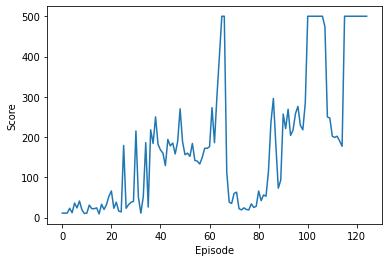

In [ ]:
# Hiperparámetros

N = 10
MAX_STEPS = 500
K_TMODEL = 5
NUMBER_OF_EPISODES = 500
MEMORY_SIZE = 150000

BATCH_SIZE = 32
LEARNING_RATE = 0.001

GAMMA = 0.99
EXPLORATION_MAX = 1
EXPLORATION_MIN = 0.005
EXPLORATION_DECAY = 0.9995

# Crear entorno y modelo de red neuronal
environment, number_of_observations, number_of_actions = create_environment()

model = keras.models.Sequential()
model.add(keras.layers.Dense(96*4, input_shape=(number_of_observations,),
          activation="selu",kernel_initializer="lecun_normal"))
model.add(keras.layers.Dense(96*4, activation="selu",kernel_initializer="lecun_normal"))
model.add(keras.layers.Dense(96*4, activation="selu",kernel_initializer="lecun_normal"))
model.add(keras.layers.Dense(48*2, activation="selu",kernel_initializer="lecun_normal"))
model.add(keras.layers.Dense(number_of_actions, activation="linear"))
model.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE))

# Lanzar modelo
agent = DQNTNetwork(number_of_observations, number_of_actions, model)
run(agent, environment)

# Anexo A: Experimentos realizados.

### E1

In [ ]:
environment, number_of_observations, number_of_actions = create_environment()

# Crear modelo
model = keras.models.Sequential()
model.add(keras.layers.Dense(24, input_shape=(number_of_observations,),
          activation="relu",kernel_initializer="he_normal"))
model.add(keras.layers.Dense(24, activation="relu",kernel_initializer="he_normal"))
model.add(keras.layers.Dense(number_of_actions, activation="linear"))
model.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE))


# Lanzar modelo
agent = DQN(number_of_observations, number_of_actions, model)
run(agent, environment)

Episode   1: score  10 (exploration rate: 1.00, transitions: 10)
Episode   2: score  15 (exploration rate: 1.00, transitions: 25)
Episode   3: score  15 (exploration rate: 1.00, transitions: 40)
Episode   4: score  12 (exploration rate: 0.99, transitions: 52)
Episode   5: score  10 (exploration rate: 0.99, transitions: 62)
Episode   6: score  90 (exploration rate: 0.94, transitions: 152)
Episode   7: score   9 (exploration rate: 0.94, transitions: 161)
Episode   8: score  34 (exploration rate: 0.92, transitions: 195)
Episode   9: score  12 (exploration rate: 0.92, transitions: 207)
Episode  10: score  25 (exploration rate: 0.90, transitions: 232)
Episode  11: score  43 (exploration rate: 0.89, transitions: 275)
Episode  12: score  11 (exploration rate: 0.88, transitions: 286)
Episode  13: score  14 (exploration rate: 0.87, transitions: 300)
Episode  14: score  18 (exploration rate: 0.87, transitions: 318)
Episode  15: score  30 (exploration rate: 0.85, transitions: 348)
Episode  16: sc

### E2

In [ ]:
# Cambios en hiperparámetros
K_TMODEL = 10
MAX_STEPS = 500
N = 3
model = keras.models.clone_model(model)
model.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE))

# Lanzar modelo
environment, number_of_observations, number_of_actions = create_environment()
agent = DQNTNetwork(number_of_observations, number_of_actions, model)
run(agent, environment)

Episode   1: score  11 (exploration rate: 1.00, transitions: 11)
Episode   2: score  11 (exploration rate: 1.00, transitions: 22)
Episode   3: score  35 (exploration rate: 0.88, transitions: 57)
Episode   4: score  10 (exploration rate: 0.84, transitions: 67)
Episode   5: score  14 (exploration rate: 0.78, transitions: 81)
Episode   6: score  15 (exploration rate: 0.73, transitions: 96)
Episode   7: score  19 (exploration rate: 0.66, transitions: 115)
Episode   8: score  26 (exploration rate: 0.58, transitions: 141)
Episode   9: score  13 (exploration rate: 0.54, transitions: 154)
Episode  10: score  11 (exploration rate: 0.51, transitions: 165)
Episode  11: score  13 (exploration rate: 0.48, transitions: 178)
Episode  12: score  16 (exploration rate: 0.44, transitions: 194)
Episode  13: score  10 (exploration rate: 0.42, transitions: 204)
Episode  14: score  16 (exploration rate: 0.39, transitions: 220)
Episode  15: score  18 (exploration rate: 0.36, transitions: 238)
Episode  16: sco

KeyboardInterrupt: ignored

### E3

Episode   1: score  13 (exploration rate: 1.00, transitions: 13)
Episode   2: score  37 (exploration rate: 0.91, transitions: 50)
Episode   3: score  12 (exploration rate: 0.86, transitions: 62)
Episode   4: score  21 (exploration rate: 0.77, transitions: 83)
Episode   5: score  18 (exploration rate: 0.71, transitions: 101)
Episode   6: score  28 (exploration rate: 0.61, transitions: 129)
Episode   7: score  11 (exploration rate: 0.58, transitions: 140)
Episode   8: score   8 (exploration rate: 0.56, transitions: 148)
Episode   9: score  10 (exploration rate: 0.53, transitions: 158)
Episode  10: score  12 (exploration rate: 0.50, transitions: 170)
Episode  11: score   9 (exploration rate: 0.48, transitions: 179)
Episode  12: score  11 (exploration rate: 0.45, transitions: 190)
Episode  13: score  10 (exploration rate: 0.43, transitions: 200)
Episode  14: score  12 (exploration rate: 0.41, transitions: 212)
Episode  15: score  10 (exploration rate: 0.39, transitions: 222)
Episode  16: s

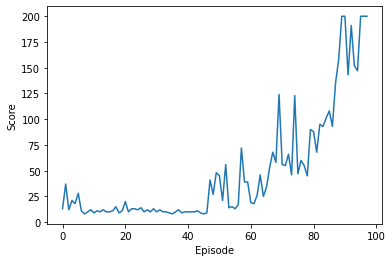

In [ ]:
# Cambios en hiperparámetros
K_TMODEL = 10
MAX_STEPS = 200
N = 3

environment, number_of_observations, number_of_actions = create_environment()

model = keras.models.Sequential()
model.add(keras.layers.Dense(24, input_shape=(number_of_observations,),
          activation="relu",kernel_initializer="he_normal"))
model.add(keras.layers.Dense(24, activation="relu",kernel_initializer="he_normal"))
model.add(keras.layers.Dense(number_of_actions, activation="linear"))
model.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE))

# Lanzar modelo
agent = DQNTNetwork(number_of_observations, number_of_actions, model)
run(agent, environment)

### E4

Episode   1: score  19 (exploration rate: 1.00, transitions: 19)
Episode   2: score  12 (exploration rate: 1.00, transitions: 31)
Episode   3: score  25 (exploration rate: 0.89, transitions: 56)
Episode   4: score  36 (exploration rate: 0.74, transitions: 92)
Episode   5: score  26 (exploration rate: 0.65, transitions: 118)
Episode   6: score  18 (exploration rate: 0.59, transitions: 136)
Episode   7: score  11 (exploration rate: 0.56, transitions: 147)
Episode   8: score  15 (exploration rate: 0.52, transitions: 162)
Episode   9: score  10 (exploration rate: 0.50, transitions: 172)
Episode  10: score  12 (exploration rate: 0.47, transitions: 184)
Episode  11: score  15 (exploration rate: 0.43, transitions: 199)
Episode  12: score  11 (exploration rate: 0.41, transitions: 210)
Episode  13: score  11 (exploration rate: 0.39, transitions: 221)
Episode  14: score   9 (exploration rate: 0.37, transitions: 230)
Episode  15: score  11 (exploration rate: 0.35, transitions: 241)
Episode  16: s

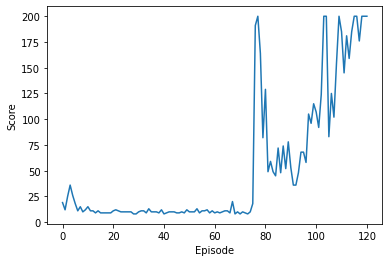

In [ ]:
# Cambios en hiperparámetros
K_TMODEL = 5
MAX_STEPS = 200
N = 3

environment, number_of_observations, number_of_actions = create_environment()

model = keras.models.Sequential()
model.add(keras.layers.Dense(24, input_shape=(number_of_observations,),
          activation="relu",kernel_initializer="he_normal"))
model.add(keras.layers.Dense(24, activation="relu",kernel_initializer="he_normal"))
model.add(keras.layers.Dense(number_of_actions, activation="linear"))
model.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE))

# Lanzar modelo
agent = DQNTNetwork(number_of_observations, number_of_actions, model)
run(agent, environment)

Disminuir el número de **k** para la actualización de TNetwork parece tardar más y necesitar de un mayor número de episodios, por lo que se va a intentar aumentar a 20. Tambien se va a reducir el rango máximo y mínimo de exploración. Cabe mencionar como a veces se alcanza el score máximo de forma prematura, pero poco después decae muy rápido. Otro dato curioso, es que parece que el aprendizaje real no empieza hasta llegar a los 3000 o 3500 transiciones.

### E5

Episode   1: score  20 (exploration rate: 0.50, transitions: 20)
Episode   2: score  27 (exploration rate: 0.46, transitions: 47)
Episode   3: score  17 (exploration rate: 0.43, transitions: 64)
Episode   4: score  14 (exploration rate: 0.40, transitions: 78)
Episode   5: score  24 (exploration rate: 0.35, transitions: 102)
Episode   6: score  24 (exploration rate: 0.31, transitions: 126)
Episode   7: score  23 (exploration rate: 0.28, transitions: 149)
Episode   8: score  10 (exploration rate: 0.26, transitions: 159)
Episode   9: score  10 (exploration rate: 0.25, transitions: 169)
Episode  10: score   9 (exploration rate: 0.24, transitions: 178)
Episode  11: score   9 (exploration rate: 0.23, transitions: 187)
Episode  12: score   9 (exploration rate: 0.22, transitions: 196)
Episode  13: score  11 (exploration rate: 0.21, transitions: 207)
Episode  14: score  10 (exploration rate: 0.20, transitions: 217)
Episode  15: score  10 (exploration rate: 0.19, transitions: 227)
Episode  16: s

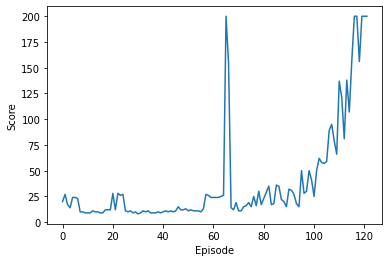

In [ ]:
# Cambios en hiperparámetros
K_TMODEL = 20
MAX_STEPS = 200
N = 3

EXPLORATION_MAX = 0.5
EXPLORATION_MIN = 0.001

environment, number_of_observations, number_of_actions = create_environment()

model = keras.models.Sequential()
model.add(keras.layers.Dense(24, input_shape=(number_of_observations,),
          activation="relu",kernel_initializer="he_normal"))
model.add(keras.layers.Dense(24, activation="relu",kernel_initializer="he_normal"))
model.add(keras.layers.Dense(number_of_actions, activation="linear"))
model.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE))

# Lanzar modelo
agent = DQNTNetwork(number_of_observations, number_of_actions, model)
run(agent, environment)

Los resultados son muy similares a los iniciales, por lo que trateré de reducir el factor de actualización de la explotación. Cuyo resultado no parece permitir a la red llegar a aprender. Por lo que voy a comenzar con un nivel de exploración máximo y mínimo algo mayor (en este caso igual que el inicial), pero manteniendo el decrecimiento de la exploración igual.

### E6

Episode   1: score  15 (exploration rate: 1.00, transitions: 15)
Episode   2: score  55 (exploration rate: 0.02, transitions: 70)
Episode   3: score  22 (exploration rate: 0.01, transitions: 92)
Episode   4: score  37 (exploration rate: 0.01, transitions: 129)
Episode   5: score  10 (exploration rate: 0.01, transitions: 139)
Episode   6: score   8 (exploration rate: 0.01, transitions: 147)
Episode   7: score   9 (exploration rate: 0.01, transitions: 156)
Episode   8: score  10 (exploration rate: 0.01, transitions: 166)
Episode   9: score  11 (exploration rate: 0.01, transitions: 177)
Episode  10: score  10 (exploration rate: 0.01, transitions: 187)
Episode  11: score  10 (exploration rate: 0.01, transitions: 197)
Episode  12: score  30 (exploration rate: 0.01, transitions: 227)
Episode  13: score   9 (exploration rate: 0.01, transitions: 236)
Episode  14: score  13 (exploration rate: 0.01, transitions: 249)
Episode  15: score  11 (exploration rate: 0.01, transitions: 260)
Episode  16: 

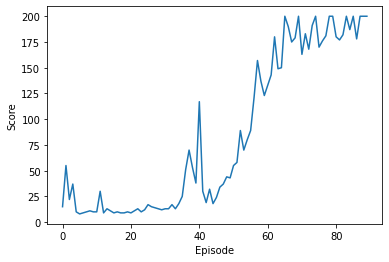

In [ ]:
# Cambios en hiperparámetros
K_TMODEL = 20
MAX_STEPS = 200
N = 3

EXPLORATION_MAX = 1
EXPLORATION_MIN = 0.005
EXPLORATION_DECAY = 0.9

environment, number_of_observations, number_of_actions = create_environment()

model = keras.models.Sequential()
model.add(keras.layers.Dense(24, input_shape=(number_of_observations,),
          activation="relu",kernel_initializer="he_normal"))
model.add(keras.layers.Dense(24, activation="relu",kernel_initializer="he_normal"))
model.add(keras.layers.Dense(number_of_actions, activation="linear"))
model.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE))

# Lanzar modelo
agent = DQNTNetwork(number_of_observations, number_of_actions, model)
run(agent, environment)

El decrementar el ratio de actualización de la exploración permite reducir el número de episodios, aunque parece aumentar el tiempo de ejecución.

### E7

Episode   1: score  20 (exploration rate: 1.00, transitions: 20)
Episode   2: score  27 (exploration rate: 0.86, transitions: 47)
Episode   3: score  15 (exploration rate: 0.74, transitions: 62)
Episode   4: score  46 (exploration rate: 0.47, transitions: 108)
Episode   5: score  22 (exploration rate: 0.37, transitions: 130)
Episode   6: score   9 (exploration rate: 0.34, transitions: 139)
Episode   7: score   9 (exploration rate: 0.31, transitions: 148)
Episode   8: score   9 (exploration rate: 0.28, transitions: 157)
Episode   9: score  10 (exploration rate: 0.26, transitions: 167)
Episode  10: score   9 (exploration rate: 0.24, transitions: 176)
Episode  11: score   9 (exploration rate: 0.21, transitions: 185)
Episode  12: score  11 (exploration rate: 0.19, transitions: 196)
Episode  13: score  11 (exploration rate: 0.17, transitions: 207)
Episode  14: score   9 (exploration rate: 0.16, transitions: 216)
Episode  15: score   9 (exploration rate: 0.14, transitions: 225)
Episode  16: 

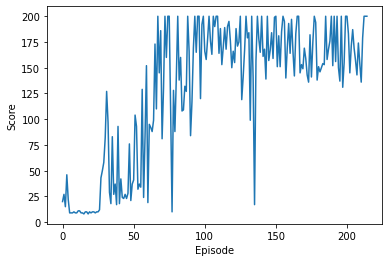

In [ ]:
# Cambios en hiperparámetros
K_TMODEL = 20
MAX_STEPS = 200
N = 3

GAMMA = 0.8
EXPLORATION_MAX = 1
EXPLORATION_MIN = 0.005
EXPLORATION_DECAY = 0.99

environment, number_of_observations, number_of_actions = create_environment()

model = keras.models.Sequential()
model.add(keras.layers.Dense(24, input_shape=(number_of_observations,),
          activation="relu",kernel_initializer="he_normal"))
model.add(keras.layers.Dense(24, activation="relu",kernel_initializer="he_normal"))
model.add(keras.layers.Dense(number_of_actions, activation="linear"))
model.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE))

# Lanzar modelo
agent = DQNTNetwork(number_of_observations, number_of_actions, model)
run(agent, environment)

Reducir el gamma impide que los pesos mantengan suficiente información del pasado haciendo que sea más dificil mantener un número alto de episodios exitosos seguidos. Se va a probar a aumentar el tamaño de la red y aumentar algo el gamma para ver si esto permite memorizar un poco más los movimientos.

### E8

Episode   1: score  28 (exploration rate: 1.00, transitions: 28)
Episode   2: score  28 (exploration rate: 0.99, transitions: 56)
Episode   3: score  16 (exploration rate: 0.98, transitions: 72)
Episode   4: score  12 (exploration rate: 0.97, transitions: 84)
Episode   5: score  19 (exploration rate: 0.97, transitions: 103)
Episode   6: score  24 (exploration rate: 0.95, transitions: 127)
Episode   7: score  12 (exploration rate: 0.95, transitions: 139)
Episode   8: score  12 (exploration rate: 0.94, transitions: 151)
Episode   9: score  17 (exploration rate: 0.93, transitions: 168)
Episode  10: score  19 (exploration rate: 0.93, transitions: 187)
Episode  11: score  11 (exploration rate: 0.92, transitions: 198)
Episode  12: score   9 (exploration rate: 0.92, transitions: 207)
Episode  13: score  20 (exploration rate: 0.91, transitions: 227)
Episode  14: score  16 (exploration rate: 0.90, transitions: 243)
Episode  15: score  24 (exploration rate: 0.89, transitions: 267)
Episode  16: s

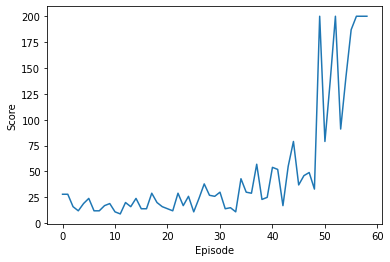

In [ ]:
# Cambios en hiperparámetros
K_TMODEL = 20
MAX_STEPS = 200
N = 3

GAMMA = 0.9
EXPLORATION_MAX = 1
EXPLORATION_MIN = 0.005
EXPLORATION_DECAY = 0.9995

environment, number_of_observations, number_of_actions = create_environment()

model = keras.models.Sequential()
model.add(keras.layers.Dense(96, input_shape=(number_of_observations,),
          activation="relu",kernel_initializer="he_normal"))
model.add(keras.layers.Dense(96, activation="relu",kernel_initializer="he_normal"))
model.add(keras.layers.Dense(number_of_actions, activation="linear"))
model.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE))

# Lanzar modelo
agent = DQNTNetwork(number_of_observations, number_of_actions, model)
run(agent, environment)

### E9

Episode   1: score  41 (exploration rate: 1.00, transitions: 41)
Episode   2: score  29 (exploration rate: 0.98, transitions: 70)
Episode   3: score  21 (exploration rate: 0.97, transitions: 91)
Episode   4: score  12 (exploration rate: 0.97, transitions: 103)
Episode   5: score  19 (exploration rate: 0.96, transitions: 122)
Episode   6: score  28 (exploration rate: 0.94, transitions: 150)
Episode   7: score  19 (exploration rate: 0.93, transitions: 169)
Episode   8: score  24 (exploration rate: 0.92, transitions: 193)
Episode   9: score  25 (exploration rate: 0.91, transitions: 218)
Episode  10: score  19 (exploration rate: 0.90, transitions: 237)
Episode  11: score  14 (exploration rate: 0.90, transitions: 251)
Episode  12: score  18 (exploration rate: 0.89, transitions: 269)
Episode  13: score  12 (exploration rate: 0.88, transitions: 281)
Episode  14: score  11 (exploration rate: 0.88, transitions: 292)
Episode  15: score  12 (exploration rate: 0.87, transitions: 304)
Episode  16: 

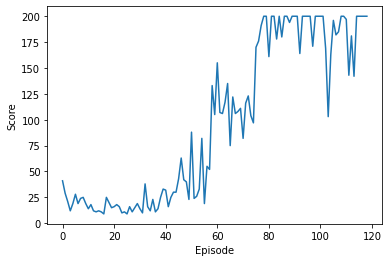

In [ ]:
# Cambios en hiperparámetros
K_TMODEL = 20
MAX_STEPS = 200
N = 5

GAMMA = 0.9
EXPLORATION_MAX = 1
EXPLORATION_MIN = 0.005
EXPLORATION_DECAY = 0.9995

environment, number_of_observations, number_of_actions = create_environment()

model = keras.models.Sequential()
model.add(keras.layers.Dense(96, input_shape=(number_of_observations,),
          activation="relu",kernel_initializer="he_normal"))
model.add(keras.layers.Dense(96, activation="relu",kernel_initializer="he_normal"))
model.add(keras.layers.Dense(number_of_actions, activation="linear"))
model.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE))

# Lanzar modelo
agent = DQNTNetwork(number_of_observations, number_of_actions, model)
run(agent, environment)

Aumentando el número de neuronas por capa (x4), se consigue aprender mucho mejor los buenos movimientos y en el mismo número de épocas y un poco menos del doble de tiempo, se consiguen una salida exitosa para N=5 en vez de N=3. 

### E10

Episode   1: score  30 (exploration rate: 1.00, transitions: 30)
Episode   2: score  10 (exploration rate: 0.92, transitions: 40)
Episode   3: score  29 (exploration rate: 0.69, transitions: 69)
Episode   4: score  10 (exploration rate: 0.62, transitions: 79)
Episode   5: score  16 (exploration rate: 0.53, transitions: 95)
Episode   6: score  11 (exploration rate: 0.48, transitions: 106)
Episode   7: score  15 (exploration rate: 0.41, transitions: 121)
Episode   8: score  11 (exploration rate: 0.37, transitions: 132)
Episode   9: score  10 (exploration rate: 0.33, transitions: 142)
Episode  10: score  10 (exploration rate: 0.30, transitions: 152)
Episode  11: score  10 (exploration rate: 0.27, transitions: 162)
Episode  12: score  14 (exploration rate: 0.24, transitions: 176)
Episode  13: score  12 (exploration rate: 0.21, transitions: 188)
Episode  14: score  12 (exploration rate: 0.18, transitions: 200)
Episode  15: score   9 (exploration rate: 0.17, transitions: 209)
Episode  16: sc

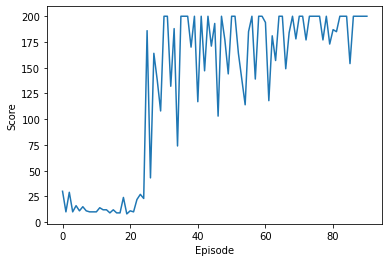

In [ ]:
# Cambios en hiperparámetros
K_TMODEL = 20
MAX_STEPS = 200
N = 5

GAMMA = 0.9
EXPLORATION_MAX = 1
EXPLORATION_MIN = 0.005
EXPLORATION_DECAY = 0.99

environment, number_of_observations, number_of_actions = create_environment()

model = keras.models.Sequential()
model.add(keras.layers.Dense(96, input_shape=(number_of_observations,),
          activation="relu",kernel_initializer="he_normal"))
model.add(keras.layers.Dense(96, activation="relu",kernel_initializer="he_normal"))
model.add(keras.layers.Dense(number_of_actions, activation="linear"))
model.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE))

# Lanzar modelo
agent = DQNTNetwork(number_of_observations, number_of_actions, model)
run(agent, environment)

Reducir de nuevo el ratio de exploración no parece ayudarle a aprender, todo lo contrario. Lo vuelve más inestable, llegando a la solución de vez en cuando pero no muchas veces seguidas.

### E11

Episode   1: score  24 (exploration rate: 1.00, transitions: 24)
Episode   2: score  11 (exploration rate: 0.99, transitions: 35)
Episode   3: score  11 (exploration rate: 0.93, transitions: 46)
Episode   4: score  16 (exploration rate: 0.86, transitions: 62)
Episode   5: score  16 (exploration rate: 0.79, transitions: 78)
Episode   6: score  18 (exploration rate: 0.73, transitions: 96)
Episode   7: score  17 (exploration rate: 0.67, transitions: 113)
Episode   8: score  11 (exploration rate: 0.63, transitions: 124)
Episode   9: score  11 (exploration rate: 0.60, transitions: 135)
Episode  10: score  24 (exploration rate: 0.53, transitions: 159)
Episode  11: score  13 (exploration rate: 0.50, transitions: 172)
Episode  12: score  19 (exploration rate: 0.45, transitions: 191)
Episode  13: score  14 (exploration rate: 0.42, transitions: 205)
Episode  14: score  14 (exploration rate: 0.39, transitions: 219)
Episode  15: score  15 (exploration rate: 0.36, transitions: 234)
Episode  16: sco

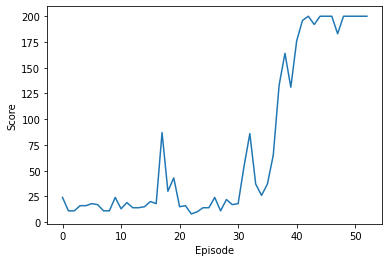

In [ ]:
# Cambios en hiperparámetros
K_TMODEL = 20
MAX_STEPS = 200
N = 5

GAMMA = 0.99
EXPLORATION_MAX = 1
EXPLORATION_MIN = 0.005
EXPLORATION_DECAY = 0.995

environment, number_of_observations, number_of_actions = create_environment()

model = keras.models.Sequential()
model.add(keras.layers.Dense(96, input_shape=(number_of_observations,),
          activation="relu",kernel_initializer="he_normal"))
model.add(keras.layers.Dense(96, activation="relu",kernel_initializer="he_normal"))
model.add(keras.layers.Dense(48, activation="relu",kernel_initializer="he_normal"))
model.add(keras.layers.Dense(number_of_actions, activation="linear"))
model.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE))

# Lanzar modelo
agent = DQNTNetwork(number_of_observations, number_of_actions, model)
run(agent, environment)

Aumentar el número de capas a 3, donde la última reduce el número de neuronas a la mitad y volver a poner los hiperparámetros originales da unos muy buenos resultados para N=5. Sobretodo destacar como al final los score parecen mucho más estables que en los casos anteriores, y esto parece ser porque se ha vuelto a aumentar gamma y eso hace que los pesos se actualicen de una forma más suavizada, dando mucho peso al conocimiento pasado. Es por ello que partiendo de la configuración anterior, se va a probar a aumentar la dimensión de N y ver el efecto.

### E12

Episode   1: score  36 (exploration rate: 1.00, transitions: 36)
Episode   2: score  23 (exploration rate: 0.99, transitions: 59)
Episode   3: score  12 (exploration rate: 0.98, transitions: 71)
Episode   4: score  15 (exploration rate: 0.97, transitions: 86)
Episode   5: score  12 (exploration rate: 0.97, transitions: 98)
Episode   6: score  10 (exploration rate: 0.96, transitions: 108)
Episode   7: score  31 (exploration rate: 0.95, transitions: 139)
Episode   8: score  20 (exploration rate: 0.94, transitions: 159)
Episode   9: score  42 (exploration rate: 0.92, transitions: 201)
Episode  10: score  16 (exploration rate: 0.91, transitions: 217)
Episode  11: score  23 (exploration rate: 0.90, transitions: 240)
Episode  12: score  23 (exploration rate: 0.89, transitions: 263)
Episode  13: score  21 (exploration rate: 0.88, transitions: 284)
Episode  14: score  20 (exploration rate: 0.87, transitions: 304)
Episode  15: score  39 (exploration rate: 0.86, transitions: 343)
Episode  16: sc

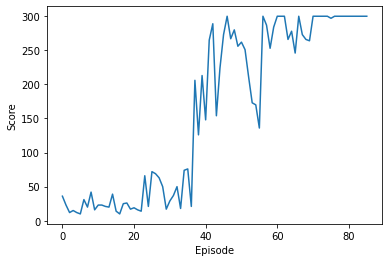

In [ ]:
# Cambios en hiperparámetros
K_TMODEL = 10
MAX_STEPS = 300
N = 10

GAMMA = 0.99
EXPLORATION_MAX = 1
EXPLORATION_MIN = 0.005
EXPLORATION_DECAY = 0.9995

environment, number_of_observations, number_of_actions = create_environment()

model = keras.models.Sequential()
model.add(keras.layers.Dense(96, input_shape=(number_of_observations,),
          activation="relu",kernel_initializer="he_normal"))
model.add(keras.layers.Dense(96, activation="relu",kernel_initializer="he_normal"))
model.add(keras.layers.Dense(48, activation="relu",kernel_initializer="he_normal"))
model.add(keras.layers.Dense(number_of_actions, activation="linear"))
model.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE))

# Lanzar modelo
agent = DQNTNetwork(number_of_observations, number_of_actions, model)
run(agent, environment)

Los resultados son muy prometedores, se ha podido aumentar el score deseado a 300 y la N a 10. Consiguiendo alcanzar la meta con la arquitectura anterior y los hiperparámetros base (decrementando un poco el valor de la exploración mínima y aumentnado el ratio de decrecimiento de la exploración). Se va a intentar mejorar algo más el score deseado pero incrementando en uno el número de capas y el multiplicando por 4 el número de neuronas.

### E13

Episode   1: score  22 (exploration rate: 1.00, transitions: 22)
Episode   2: score  23 (exploration rate: 0.99, transitions: 45)
Episode   3: score  19 (exploration rate: 0.98, transitions: 64)
Episode   4: score  14 (exploration rate: 0.98, transitions: 78)
Episode   5: score  12 (exploration rate: 0.97, transitions: 90)
Episode   6: score  23 (exploration rate: 0.96, transitions: 113)
Episode   7: score  20 (exploration rate: 0.95, transitions: 133)
Episode   8: score  26 (exploration rate: 0.94, transitions: 159)
Episode   9: score  13 (exploration rate: 0.93, transitions: 172)
Episode  10: score  18 (exploration rate: 0.92, transitions: 190)
Episode  11: score  14 (exploration rate: 0.92, transitions: 204)
Episode  12: score  15 (exploration rate: 0.91, transitions: 219)
Episode  13: score  22 (exploration rate: 0.90, transitions: 241)
Episode  14: score  24 (exploration rate: 0.89, transitions: 265)
Episode  15: score  29 (exploration rate: 0.88, transitions: 294)
Episode  16: sc

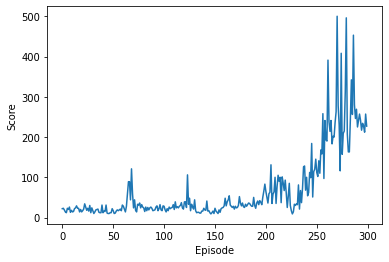

In [ ]:
# Cambios en hiperparámetros
K_TMODEL = 10
MAX_STEPS = 500
N = 10

GAMMA = 0.99
EXPLORATION_MAX = 1
EXPLORATION_MIN = 0.005
EXPLORATION_DECAY = 0.9995

environment, number_of_observations, number_of_actions = create_environment()

model = keras.models.Sequential()
model.add(keras.layers.Dense(96*4, input_shape=(number_of_observations,),
          activation="relu",kernel_initializer="he_normal"))
model.add(keras.layers.Dense(96*4, activation="relu",kernel_initializer="he_normal"))
model.add(keras.layers.Dense(96*4, activation="relu",kernel_initializer="he_normal"))
model.add(keras.layers.Dense(48*2, activation="relu",kernel_initializer="he_normal"))
model.add(keras.layers.Dense(number_of_actions, activation="linear"))
model.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE))

# Lanzar modelo
agent = DQNTNetwork(number_of_observations, number_of_actions, model)
run(agent, environment)

### E14

Episode   1: score  35 (exploration rate: 1.00, transitions: 35)
Episode   2: score  20 (exploration rate: 0.99, transitions: 55)
Episode   3: score  23 (exploration rate: 0.98, transitions: 78)
Episode   4: score  12 (exploration rate: 0.97, transitions: 90)
Episode   5: score  22 (exploration rate: 0.96, transitions: 112)
Episode   6: score  16 (exploration rate: 0.95, transitions: 128)
Episode   7: score  14 (exploration rate: 0.95, transitions: 142)
Episode   8: score  10 (exploration rate: 0.94, transitions: 152)
Episode   9: score  13 (exploration rate: 0.94, transitions: 165)
Episode  10: score  24 (exploration rate: 0.92, transitions: 189)
Episode  11: score  19 (exploration rate: 0.92, transitions: 208)
Episode  12: score  26 (exploration rate: 0.90, transitions: 234)
Episode  13: score  37 (exploration rate: 0.89, transitions: 271)
Episode  14: score  11 (exploration rate: 0.88, transitions: 282)
Episode  15: score  14 (exploration rate: 0.88, transitions: 296)
Episode  16: s

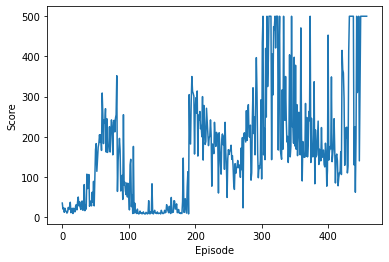

In [ ]:
# Cambios en hiperparámetros
K_TMODEL = 10
N = 10

MAX_STEPS = 500
NUMBER_OF_EPISODES = 500
MEMORY_SIZE = 300000

BATCH_SIZE = 32
LEARNING_RATE = 0.001

GAMMA = 0.99
EXPLORATION_MAX = 1
EXPLORATION_MIN = 0.005
EXPLORATION_DECAY = 0.9995

environment, number_of_observations, number_of_actions = create_environment()

model = keras.models.Sequential()
model.add(keras.layers.Dense(96*4, input_shape=(number_of_observations,),
          activation="relu",kernel_initializer="he_normal"))
model.add(keras.layers.Dense(96*4, activation="relu",kernel_initializer="he_normal"))
model.add(keras.layers.Dense(96*4, activation="relu",kernel_initializer="he_normal"))
model.add(keras.layers.Dense(48*2, activation="relu",kernel_initializer="he_normal"))
model.add(keras.layers.Dense(number_of_actions, activation="linear"))
model.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE))

# Lanzar modelo
agent = DQNTNetwork(number_of_observations, number_of_actions, model)
run(agent, environment)

Ha sido necesario un incremento en el tamaño de la memoria para que la red aprenda, una vez hecho, se logra alcanzar un score de 500 10 veces seguidas con éxito.

### E15

Episode   1: score  14 (exploration rate: 1.00, transitions: 14)
Episode   2: score  29 (exploration rate: 1.00, transitions: 43)
Episode   3: score  10 (exploration rate: 1.00, transitions: 53)
Episode   4: score  24 (exploration rate: 1.00, transitions: 77)
Episode   5: score  13 (exploration rate: 1.00, transitions: 90)
Episode   6: score  14 (exploration rate: 1.00, transitions: 104)
Episode   7: score  18 (exploration rate: 1.00, transitions: 122)
Episode   8: score  19 (exploration rate: 1.00, transitions: 141)
Episode   9: score  15 (exploration rate: 0.99, transitions: 156)
Episode  10: score  93 (exploration rate: 0.98, transitions: 249)
Episode  11: score  34 (exploration rate: 0.97, transitions: 283)
Episode  12: score  14 (exploration rate: 0.97, transitions: 297)
Episode  13: score  13 (exploration rate: 0.96, transitions: 310)
Episode  14: score  23 (exploration rate: 0.96, transitions: 333)
Episode  15: score  17 (exploration rate: 0.96, transitions: 350)
Episode  16: sc

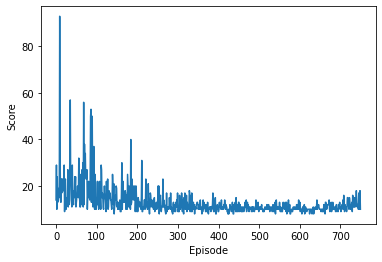

In [ ]:
# Cambios en hiperparámetros
K_TMODEL = 10
N = 10

MAX_STEPS = 750
NUMBER_OF_EPISODES = 750
MEMORY_SIZE = 1000000

BATCH_SIZE = 128
LEARNING_RATE = 0.0005

GAMMA = 0.99
EXPLORATION_MAX = 1
EXPLORATION_MIN = 0.005
EXPLORATION_DECAY = 0.9998

environment, number_of_observations, number_of_actions = create_environment()

model = keras.models.Sequential()
model.add(keras.layers.Dense(96*4, input_shape=(number_of_observations,), activation="linear",kernel_initializer="he_normal"))
model.add(keras.layers.PReLU())
model.add(keras.layers.Dense(96*4, activation="linear",kernel_initializer="he_normal"))
model.add(keras.layers.PReLU())
model.add(keras.layers.Dense(96*4, activation="linear",kernel_initializer="he_normal"))
model.add(keras.layers.PReLU())
model.add(keras.layers.Dense(48*2, activation="linear",kernel_initializer="he_normal"))
model.add(keras.layers.PReLU())
model.add(keras.layers.Dense(number_of_actions, activation="linear"))
model.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE))

# Lanzar modelo
agent = DQNTNetwork(number_of_observations, number_of_actions, model)
run(agent, environment)

Intentando mejorar el score, se prueba a cambiar la función de activación por PReLU, que es una LeakyReLU cuyo threshold se aprende. La red es incapaz de aprender con esta función de activación (aunque posiblemente falta más tiempo)

### E16

Episode   1: score  11 (exploration rate: 1.00, transitions: 11)
Episode   2: score  18 (exploration rate: 1.00, transitions: 29)
Episode   3: score  25 (exploration rate: 1.00, transitions: 54)
Episode   4: score  11 (exploration rate: 1.00, transitions: 65)
Episode   5: score  20 (exploration rate: 0.99, transitions: 85)
Episode   6: score  18 (exploration rate: 0.98, transitions: 103)
Episode   7: score  19 (exploration rate: 0.98, transitions: 122)
Episode   8: score  35 (exploration rate: 0.96, transitions: 157)
Episode   9: score  26 (exploration rate: 0.95, transitions: 183)
Episode  10: score  34 (exploration rate: 0.94, transitions: 217)
Episode  11: score  15 (exploration rate: 0.93, transitions: 232)
Episode  12: score  22 (exploration rate: 0.93, transitions: 254)
Episode  13: score  26 (exploration rate: 0.92, transitions: 280)
Episode  14: score  31 (exploration rate: 0.91, transitions: 311)
Episode  15: score  10 (exploration rate: 0.90, transitions: 321)
Episode  16: sc

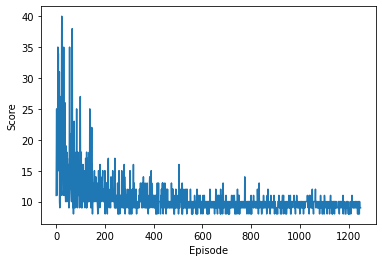

In [ ]:
# Cambios en hiperparámetros
K_TMODEL = 15
N = 10

MAX_STEPS = 750
NUMBER_OF_EPISODES = 1250
MEMORY_SIZE = 1000000

BATCH_SIZE = 64
LEARNING_RATE = 0.0005

GAMMA = 0.999
EXPLORATION_MAX = 1
EXPLORATION_MIN = 0.005
EXPLORATION_DECAY = 0.9996

environment, number_of_observations, number_of_actions = create_environment()

model = keras.models.Sequential()
model.add(keras.layers.Dense(96*4, input_shape=(number_of_observations,), activation="linear",kernel_initializer="he_normal"))
model.add(keras.layers.Dense(96*4, activation="relu",kernel_initializer="he_normal"))
model.add(keras.layers.Dense(96*4, activation="relu",kernel_initializer="he_normal"))
model.add(keras.layers.Dense(48*2, activation="relu",kernel_initializer="he_normal"))
model.add(keras.layers.Dense(48*2, activation="relu",kernel_initializer="he_normal"))
model.add(keras.layers.Dense(number_of_actions, activation="linear"))
model.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE))

# Lanzar modelo
agent = DQNTNetwork(number_of_observations, number_of_actions, model)
run(agent, environment)

Volviendo a PReLU y añadiendo una capa más, la red aún es incapaz de aprender

### E17

Episode   1: score  16 (exploration rate: 0.99, transitions: 16)
Episode   2: score  12 (exploration rate: 0.99, transitions: 28)
Episode   3: score  32 (exploration rate: 0.98, transitions: 60)
Episode   4: score  14 (exploration rate: 0.97, transitions: 74)
Episode   5: score  11 (exploration rate: 0.97, transitions: 85)
Episode   6: score  12 (exploration rate: 0.96, transitions: 97)
Episode   7: score  11 (exploration rate: 0.96, transitions: 108)
Episode   8: score  15 (exploration rate: 0.95, transitions: 123)
Episode   9: score  14 (exploration rate: 0.95, transitions: 137)
Episode  10: score  23 (exploration rate: 0.94, transitions: 160)
Episode  11: score  35 (exploration rate: 0.93, transitions: 195)
Episode  12: score  11 (exploration rate: 0.92, transitions: 206)
Episode  13: score  25 (exploration rate: 0.91, transitions: 231)
Episode  14: score  14 (exploration rate: 0.91, transitions: 245)
Episode  15: score  17 (exploration rate: 0.90, transitions: 262)
Episode  16: sco

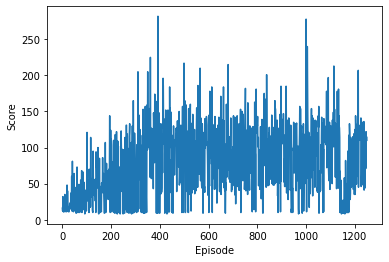

In [ ]:
# Cambios en hiperparámetros
K_TMODEL = 1
N = 10

MAX_STEPS = 750
NUMBER_OF_EPISODES = 1250
MEMORY_SIZE = 1000000

BATCH_SIZE = 1
LEARNING_RATE = 0.0005

GAMMA = 0.999
EXPLORATION_MAX = 1
EXPLORATION_MIN = 0.005
EXPLORATION_DECAY = 0.9996

environment, number_of_observations, number_of_actions = create_environment()

model = keras.models.Sequential()
model.add(keras.layers.Dense(96*4, input_shape=(number_of_observations,), activation="relu",kernel_initializer="he_normal"))
model.add(keras.layers.Dense(96*4, activation="relu",kernel_initializer="he_normal"))
model.add(keras.layers.Dense(96*4, activation="relu",kernel_initializer="he_normal"))
model.add(keras.layers.Dense(48*2, activation="relu",kernel_initializer="he_normal"))
model.add(keras.layers.Dense(48*2, activation="relu",kernel_initializer="he_normal"))
model.add(keras.layers.Dense(number_of_actions, activation="linear"))
model.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE))
 
# Lanzar modelo
agent = DQNTNetwork(number_of_observations, number_of_actions, model)
run(agent, environment)

In [ ]:
BATCH_SIZE = 64
run(agent, environment)

Episode   1: score 106 (exploration rate: 0.01, transitions: 97466)
Episode   2: score  67 (exploration rate: 0.01, transitions: 97533)
Episode   3: score 135 (exploration rate: 0.01, transitions: 97668)
Episode   4: score  64 (exploration rate: 0.01, transitions: 97732)
Episode   5: score 130 (exploration rate: 0.01, transitions: 97862)
Episode   6: score  71 (exploration rate: 0.01, transitions: 97933)
Episode   7: score 113 (exploration rate: 0.01, transitions: 98046)
Episode   8: score 113 (exploration rate: 0.01, transitions: 98159)
Episode   9: score 112 (exploration rate: 0.01, transitions: 98271)
Episode  10: score  37 (exploration rate: 0.01, transitions: 98308)
Episode  11: score  66 (exploration rate: 0.01, transitions: 98374)
Episode  12: score 116 (exploration rate: 0.01, transitions: 98490)
Episode  13: score 114 (exploration rate: 0.01, transitions: 98604)
Episode  14: score  49 (exploration rate: 0.01, transitions: 98653)
Episode  15: score  69 (exploration rate: 0.01, 

KeyboardInterrupt: ignored

Se ha intentado entrenar el modelo con una capa más, y primero con un batch size pequeño y después con uno más grande, trabajando además con un k pequeño, pues se estaban haciendo muy pocas transiciones. No da buenos resultados.

### E18

Episode   1: score  20 (exploration rate: 1.00, transitions: 20)
Episode   2: score  12 (exploration rate: 1.00, transitions: 32)
Episode   3: score  32 (exploration rate: 1.00, transitions: 64)
Episode   4: score  16 (exploration rate: 1.00, transitions: 80)
Episode   5: score  15 (exploration rate: 0.99, transitions: 95)
Episode   6: score  16 (exploration rate: 0.99, transitions: 111)
Episode   7: score  36 (exploration rate: 0.99, transitions: 147)
Episode   8: score  11 (exploration rate: 0.99, transitions: 158)
Episode   9: score  10 (exploration rate: 0.99, transitions: 168)
Episode  10: score  36 (exploration rate: 0.98, transitions: 204)
Episode  11: score  32 (exploration rate: 0.98, transitions: 236)
Episode  12: score  16 (exploration rate: 0.98, transitions: 252)
Episode  13: score  13 (exploration rate: 0.98, transitions: 265)
Episode  14: score  14 (exploration rate: 0.98, transitions: 279)
Episode  15: score  12 (exploration rate: 0.97, transitions: 291)
Episode  16: sc

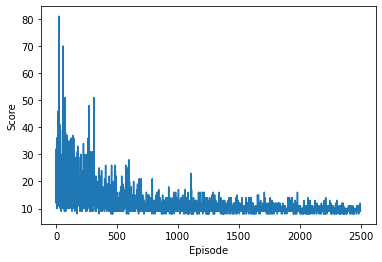

In [ ]:
# Cambios en hiperparámetros
K_TMODEL = 10
N = 10

MAX_STEPS = 750
NUMBER_OF_EPISODES = 2500
MEMORY_SIZE = 1000000

BATCH_SIZE = 32
LEARNING_RATE = 0.001

GAMMA = 0.99
EXPLORATION_MAX = 1
EXPLORATION_MIN = 0.005
EXPLORATION_DECAY = 0.9999

environment, number_of_observations, number_of_actions = create_environment()

model = keras.models.Sequential()
model.add(keras.layers.Dense(96*4, input_shape=(number_of_observations,),
          activation="relu",kernel_initializer="he_normal"))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(96*4, activation="relu",kernel_initializer="he_normal"))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(96*4, activation="relu",kernel_initializer="he_normal"))
model.add(keras.layers.PReLU())
model.add(keras.layers.Dense(48*2, activation="relu",kernel_initializer="he_normal"))
model.add(keras.layers.Dense(number_of_actions, activation="linear"))
model.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE))

# Lanzar modelo
agent = DQNTNetwork(number_of_observations, number_of_actions, model)
run(agent, environment)

Se ha probado a añadir batch normalization y PReLU en una sola capa, no parece ayudar al aprendizaje.

### E19

Episode   1: score  19 (exploration rate: 1.00, transitions: 19)
Episode   2: score  13 (exploration rate: 1.00, transitions: 32)
Episode   3: score  53 (exploration rate: 0.97, transitions: 85)
Episode   4: score   9 (exploration rate: 0.97, transitions: 94)
Episode   5: score  23 (exploration rate: 0.96, transitions: 117)
Episode   6: score  22 (exploration rate: 0.95, transitions: 139)
Episode   7: score  11 (exploration rate: 0.94, transitions: 150)
Episode   8: score  15 (exploration rate: 0.94, transitions: 165)
Episode   9: score  10 (exploration rate: 0.93, transitions: 175)
Episode  10: score  25 (exploration rate: 0.92, transitions: 200)
Episode  11: score  19 (exploration rate: 0.91, transitions: 219)
Episode  12: score   9 (exploration rate: 0.91, transitions: 228)
Episode  13: score  45 (exploration rate: 0.89, transitions: 273)
Episode  14: score  26 (exploration rate: 0.87, transitions: 299)
Episode  15: score  16 (exploration rate: 0.87, transitions: 315)
Episode  16: s

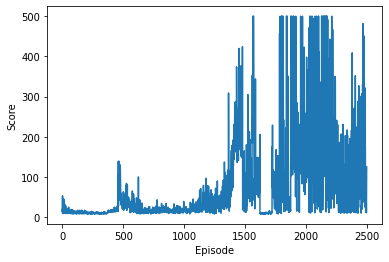

In [ ]:
# Cambios en hiperparámetros
K_TMODEL = 10
N = 10

MAX_STEPS = 750
NUMBER_OF_EPISODES = 2500
MEMORY_SIZE = 1000000

BATCH_SIZE = 32
LEARNING_RATE = 0.001

GAMMA = 0.99
EXPLORATION_MAX = 1
EXPLORATION_MIN = 0.005
EXPLORATION_DECAY = 0.9995

environment, number_of_observations, number_of_actions = create_environment()

model = keras.models.Sequential()
model.add(keras.layers.Dense(96*4, input_shape=(number_of_observations,),
          activation="relu",kernel_initializer="he_normal"))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(96*4, activation="relu",kernel_initializer="he_normal"))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(96*4, activation="relu",kernel_initializer="he_normal"))
model.add(keras.layers.Dense(48*2, activation="relu",kernel_initializer="he_normal"))
model.add(keras.layers.Dense(number_of_actions, activation="linear"))
model.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE))

# Lanzar modelo
agent = DQNTNetwork(number_of_observations, number_of_actions, model)
run(agent, environment)

Prueba a utilizar red más grande con Dropout, no se mejora la mejor solución anterior, parece atascado en score de 500...

### E20

In [ ]:
# Cambios en hiperparámetros
K_TMODEL = 10
N = 10

MAX_STEPS = 750
NUMBER_OF_EPISODES = 2500
MEMORY_SIZE = 1000000

BATCH_SIZE = 32
LEARNING_RATE = 0.001

GAMMA = 0.99
EXPLORATION_MAX = 1
EXPLORATION_MIN = 0.005
EXPLORATION_DECAY = 0.9995

environment, number_of_observations, number_of_actions = create_environment()

model = keras.models.Sequential()
model.add(keras.layers.Dense(96*4, input_shape=(number_of_observations,),
          activation="selu",kernel_initializer="lecun_normal"))
model.add(keras.layers.Dense(96*4, activation="selu",kernel_initializer="lecun_normal"))
model.add(keras.layers.Dense(96*4, activation="selu",kernel_initializer="lecun_normal"))
model.add(keras.layers.Dense(48*2, activation="selu",kernel_initializer="lecun_normal"))
model.add(keras.layers.Dense(number_of_actions, activation="linear"))
model.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE))

# Lanzar modelo
agent = DQNTNetwork(number_of_observations, number_of_actions, model)
run(agent, environment)

Episode   1: score  13 (exploration rate: 1.00, transitions: 13)
Episode   2: score  15 (exploration rate: 1.00, transitions: 28)
Episode   3: score  20 (exploration rate: 0.99, transitions: 48)
Episode   4: score  29 (exploration rate: 0.98, transitions: 77)
Episode   5: score  31 (exploration rate: 0.96, transitions: 108)
Episode   6: score  16 (exploration rate: 0.96, transitions: 124)
Episode   7: score  12 (exploration rate: 0.95, transitions: 136)
Episode   8: score  23 (exploration rate: 0.94, transitions: 159)
Episode   9: score  10 (exploration rate: 0.93, transitions: 169)
Episode  10: score  23 (exploration rate: 0.92, transitions: 192)
Episode  11: score  66 (exploration rate: 0.89, transitions: 258)
Episode  12: score  45 (exploration rate: 0.87, transitions: 303)
Episode  13: score  40 (exploration rate: 0.86, transitions: 343)
Episode  14: score  28 (exploration rate: 0.84, transitions: 371)
Episode  15: score  24 (exploration rate: 0.83, transitions: 395)
Episode  16: s

Tiene un aprendizaje estable, similar a los mejores resultados hasta ahora, también parece atascado en score de 500, pese a estar el límite fijado a 750.

### E21

Episode   1: score  14 (exploration rate: 1.00, transitions: 14)
Episode   2: score  42 (exploration rate: 1.00, transitions: 56)
Episode   3: score   9 (exploration rate: 1.00, transitions: 65)
Episode   4: score  14 (exploration rate: 1.00, transitions: 79)
Episode   5: score  13 (exploration rate: 1.00, transitions: 92)
Episode   6: score  11 (exploration rate: 1.00, transitions: 103)
Episode   7: score  11 (exploration rate: 1.00, transitions: 114)
Episode   8: score  17 (exploration rate: 1.00, transitions: 131)
Episode   9: score  46 (exploration rate: 0.99, transitions: 177)
Episode  10: score  11 (exploration rate: 0.99, transitions: 188)
Episode  11: score  29 (exploration rate: 0.99, transitions: 217)
Episode  12: score  37 (exploration rate: 0.99, transitions: 254)
Episode  13: score  16 (exploration rate: 0.99, transitions: 270)
Episode  14: score  27 (exploration rate: 0.99, transitions: 297)
Episode  15: score  18 (exploration rate: 0.99, transitions: 315)
Episode  16: sc

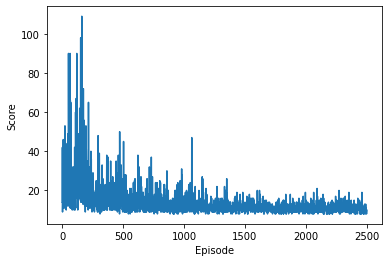

In [ ]:
# Cambios en hiperparámetros
K_TMODEL = 10
N = 5

MAX_STEPS = 750
NUMBER_OF_EPISODES = 2500
MEMORY_SIZE = 1000000

BATCH_SIZE = 32
LEARNING_RATE = 0.001

GAMMA = 0.99
EXPLORATION_MAX = 1
EXPLORATION_MIN = 0.005
EXPLORATION_DECAY = 0.99995

environment, number_of_observations, number_of_actions = create_environment()

model = keras.models.Sequential()
model.add(keras.layers.Dense(96*4, input_shape=(number_of_observations,),
          activation="selu",kernel_initializer="lecun_normal"))
model.add(keras.layers.Dense(96*4, activation="selu",kernel_initializer="lecun_normal"))
model.add(keras.layers.Dense(96*4, activation="selu",kernel_initializer="lecun_normal"))
model.add(keras.layers.Dense(48*2, activation="selu",kernel_initializer="lecun_normal"))
model.add(keras.layers.Dense(number_of_actions, activation="linear"))
model.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE))

# Lanzar modelo
agent = DQNTNetwork(number_of_observations, number_of_actions, model)
run(agent, environment)

La prueba de aumentar la exploración parece no haber dado resultados. Quizás la red necesita aún más épocas para llegar a la parte de intensificación.

### E22

Episode   1: score  11 (exploration rate: 1.00, transitions: 11)
Episode   2: score  11 (exploration rate: 1.00, transitions: 22)
Episode   3: score  11 (exploration rate: 1.00, transitions: 33)
Episode   4: score  23 (exploration rate: 0.99, transitions: 56)
Episode   5: score  12 (exploration rate: 0.98, transitions: 68)
Episode   6: score  36 (exploration rate: 0.96, transitions: 104)
Episode   7: score  24 (exploration rate: 0.95, transitions: 128)
Episode   8: score  41 (exploration rate: 0.93, transitions: 169)
Episode   9: score  19 (exploration rate: 0.92, transitions: 188)
Episode  10: score  10 (exploration rate: 0.92, transitions: 198)
Episode  11: score  11 (exploration rate: 0.92, transitions: 209)
Episode  12: score  31 (exploration rate: 0.90, transitions: 240)
Episode  13: score  22 (exploration rate: 0.89, transitions: 262)
Episode  14: score  22 (exploration rate: 0.88, transitions: 284)
Episode  15: score  24 (exploration rate: 0.87, transitions: 308)
Episode  16: sc

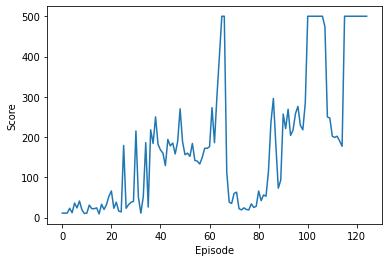

In [16]:
# Cambios en hiperparámetros
K_TMODEL = 5
N = 10

MAX_STEPS = 500
NUMBER_OF_EPISODES = 500 # Bajados porque no hacen falta más parece
MEMORY_SIZE = 150000 # dividido /10

BATCH_SIZE = 32
LEARNING_RATE = 0.001

GAMMA = 0.99
EXPLORATION_MAX = 1
EXPLORATION_MIN = 0.005
EXPLORATION_DECAY = 0.9995 # Reducido el decay de exploration

environment, number_of_observations, number_of_actions = create_environment()

model = keras.models.Sequential()
model.add(keras.layers.Dense(96*4, input_shape=(number_of_observations,),
          activation="selu",kernel_initializer="lecun_normal"))
model.add(keras.layers.Dense(96*4, activation="selu",kernel_initializer="lecun_normal"))
model.add(keras.layers.Dense(96*4, activation="selu",kernel_initializer="lecun_normal"))
model.add(keras.layers.Dense(48*2, activation="selu",kernel_initializer="lecun_normal"))
model.add(keras.layers.Dense(number_of_actions, activation="linear"))
model.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE))

# Lanzar modelo
agent = DQNTNetwork(number_of_observations, number_of_actions, model)
run(agent, environment)

Este experimento parece haber dado buenos resultados, y haber conseguido mejorar el aprendizaje de la red. Parece que aprende antes y de forma más estable

### E23

Episode   1: score  80 (exploration rate: 0.99, transitions: 80)
Episode   2: score  41 (exploration rate: 0.97, transitions: 121)
Episode   3: score  19 (exploration rate: 0.97, transitions: 140)
Episode   4: score  15 (exploration rate: 0.96, transitions: 155)
Episode   5: score  50 (exploration rate: 0.95, transitions: 205)
Episode   6: score  11 (exploration rate: 0.95, transitions: 216)
Episode   7: score  20 (exploration rate: 0.94, transitions: 236)
Episode   8: score  27 (exploration rate: 0.93, transitions: 263)
Episode   9: score  42 (exploration rate: 0.92, transitions: 305)
Episode  10: score  21 (exploration rate: 0.92, transitions: 326)
Episode  11: score  13 (exploration rate: 0.91, transitions: 339)
Episode  12: score  15 (exploration rate: 0.91, transitions: 354)
Episode  13: score  20 (exploration rate: 0.90, transitions: 374)
Episode  14: score  18 (exploration rate: 0.90, transitions: 392)
Episode  15: score  13 (exploration rate: 0.89, transitions: 405)
Episode  16

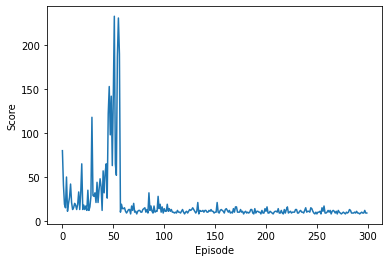

In [ ]:
# Cambios en hiperparámetros
K_TMODEL = 5
N = 5

MAX_STEPS = 750
NUMBER_OF_EPISODES = 300
MEMORY_SIZE = 100000 # dividido /10

BATCH_SIZE = 32
LEARNING_RATE = 0.001

GAMMA = 0.99
EXPLORATION_MAX = 1
EXPLORATION_MIN = 0.005
EXPLORATION_DECAY = 0.9997 # Reducido el decay de exploration

environment, number_of_observations, number_of_actions = create_environment()

model = keras.models.Sequential()
model.add(keras.layers.Dense(96*4, input_shape=(number_of_observations,),
          activation="selu",kernel_initializer="lecun_normal"))
model.add(keras.layers.Dense(96*4, activation="selu",kernel_initializer="lecun_normal"))
model.add(keras.layers.Dense(96*4, activation="selu",kernel_initializer="lecun_normal"))
model.add(keras.layers.Dense(96*4, activation="selu",kernel_initializer="lecun_normal"))
model.add(keras.layers.Dense(48*2, activation="selu",kernel_initializer="lecun_normal"))
model.add(keras.layers.Dense(number_of_actions, activation="linear"))
model.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE))

# Lanzar modelo
agent = DQNTNetwork(number_of_observations, number_of_actions, model)
run(agent, environment)

Parece que añadir una capa más no mejora los resultados, como si la red no fuera capaz de aprender más


### E24

Episode   1: score  15 (exploration rate: 1.00, transitions: 15)
Episode   2: score  11 (exploration rate: 1.00, transitions: 26)
Episode   3: score  18 (exploration rate: 1.00, transitions: 44)
Episode   4: score  19 (exploration rate: 0.99, transitions: 63)
Episode   5: score  22 (exploration rate: 0.99, transitions: 85)
Episode   6: score  23 (exploration rate: 0.98, transitions: 108)
Episode   7: score  14 (exploration rate: 0.98, transitions: 122)
Episode   8: score  19 (exploration rate: 0.98, transitions: 141)
Episode   9: score  22 (exploration rate: 0.97, transitions: 163)
Episode  10: score  21 (exploration rate: 0.97, transitions: 184)
Episode  11: score  14 (exploration rate: 0.97, transitions: 198)
Episode  12: score  12 (exploration rate: 0.97, transitions: 210)
Episode  13: score  13 (exploration rate: 0.96, transitions: 223)
Episode  14: score  53 (exploration rate: 0.95, transitions: 276)
Episode  15: score  42 (exploration rate: 0.94, transitions: 318)
Episode  16: sc

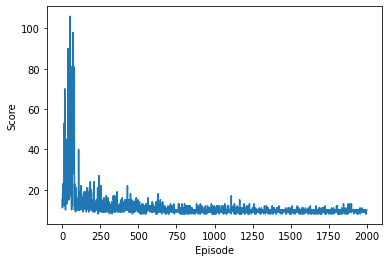

In [ ]:
# Cambios en hiperparámetros
K_TMODEL = 4 # Reducido el K aún más
N = 5

MAX_STEPS = 750
NUMBER_OF_EPISODES = 2000 # Aumentado el número de épocas
MEMORY_SIZE = 10000 # dividido /100

BATCH_SIZE = 32
LEARNING_RATE = 0.001

GAMMA = 0.99
EXPLORATION_MAX = 1
EXPLORATION_MIN = 0.005
EXPLORATION_DECAY = 0.9998 # Reducido el decay de exploration aún más

environment, number_of_observations, number_of_actions = create_environment()

model = keras.models.Sequential()
model.add(keras.layers.Dense(96*4, input_shape=(number_of_observations,),
          activation="selu",kernel_initializer="lecun_normal"))
model.add(keras.layers.Dense(96*4, activation="selu",kernel_initializer="lecun_normal"))
model.add(keras.layers.Dense(96*4, activation="selu",kernel_initializer="lecun_normal"))
model.add(keras.layers.Dense(96*4, activation="selu",kernel_initializer="lecun_normal"))
model.add(keras.layers.Dense(48*2, activation="selu",kernel_initializer="lecun_normal"))
model.add(keras.layers.Dense(number_of_actions, activation="linear"))
model.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE))

# Lanzar modelo
agent = DQNTNetwork(number_of_observations, number_of_actions, model)
run(agent, environment)

Parece que tras haber tocado los hiper parámetros tampoco hemos obtenido mejores resultados

### E25

Episode   1: score  11 (exploration rate: 1.00, transitions: 11)
Episode   2: score  31 (exploration rate: 1.00, transitions: 42)
Episode   3: score  21 (exploration rate: 1.00, transitions: 63)
Episode   4: score  12 (exploration rate: 1.00, transitions: 75)
Episode   5: score  38 (exploration rate: 0.99, transitions: 113)
Episode   6: score  15 (exploration rate: 0.98, transitions: 128)
Episode   7: score  59 (exploration rate: 0.96, transitions: 187)
Episode   8: score  16 (exploration rate: 0.96, transitions: 203)
Episode   9: score  12 (exploration rate: 0.96, transitions: 215)
Episode  10: score  18 (exploration rate: 0.95, transitions: 233)
Episode  11: score  10 (exploration rate: 0.95, transitions: 243)
Episode  12: score  26 (exploration rate: 0.94, transitions: 269)
Episode  13: score  12 (exploration rate: 0.94, transitions: 281)
Episode  14: score  18 (exploration rate: 0.93, transitions: 299)
Episode  15: score  10 (exploration rate: 0.93, transitions: 309)
Episode  16: s

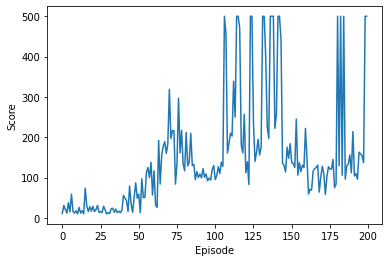

In [ ]:
# Cambios en hiperparámetros
K_TMODEL = 5
N = 5

MAX_STEPS = 750
NUMBER_OF_EPISODES = 200 # Bajados porque no hacen falta más parece
MEMORY_SIZE = 100000 # dividido /10

BATCH_SIZE = 64
LEARNING_RATE = 0.001

GAMMA = 0.99
EXPLORATION_MAX = 1
EXPLORATION_MIN = 0.005
EXPLORATION_DECAY = 0.9997 # Reducido el decay de exploration

environment, number_of_observations, number_of_actions = create_environment()

model = keras.models.Sequential()
model.add(keras.layers.Dense(96*4, input_shape=(number_of_observations,),
          activation="selu",kernel_initializer="lecun_normal"))
model.add(keras.layers.Dense(96*4, activation="selu",kernel_initializer="lecun_normal"))
model.add(keras.layers.Dense(48*2, activation="selu",kernel_initializer="lecun_normal"))
model.add(keras.layers.Dense(number_of_actions, activation="linear"))
model.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE))

# Lanzar modelo
agent = DQNTNetwork(number_of_observations, number_of_actions, model)
run(agent, environment)

Parece que con una red más simple hemos conseguido aprender, sin embargo parece que es bastante inestable el aprendizaje obtenido

### E26

Episode   1: score  24 (exploration rate: 1.00, transitions: 24)
Episode   2: score  43 (exploration rate: 1.00, transitions: 67)
Episode   3: score  24 (exploration rate: 0.99, transitions: 91)
Episode   4: score  16 (exploration rate: 0.99, transitions: 107)
Episode   5: score  13 (exploration rate: 0.98, transitions: 120)
Episode   6: score  14 (exploration rate: 0.98, transitions: 134)
Episode   7: score  11 (exploration rate: 0.98, transitions: 145)
Episode   8: score  13 (exploration rate: 0.97, transitions: 158)
Episode   9: score  17 (exploration rate: 0.97, transitions: 175)
Episode  10: score  20 (exploration rate: 0.96, transitions: 195)
Episode  11: score  23 (exploration rate: 0.95, transitions: 218)
Episode  12: score  16 (exploration rate: 0.95, transitions: 234)
Episode  13: score  22 (exploration rate: 0.94, transitions: 256)
Episode  14: score  41 (exploration rate: 0.93, transitions: 297)
Episode  15: score  21 (exploration rate: 0.93, transitions: 318)
Episode  16: 

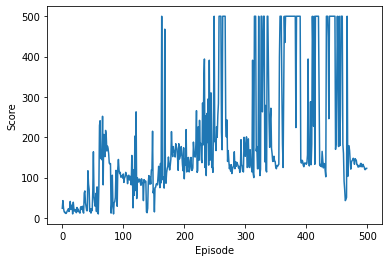

In [ ]:
# Cambios en hiperparámetros
K_TMODEL = 10
N = 5

MAX_STEPS = 750
NUMBER_OF_EPISODES = 500 # Bajados porque no hacen falta más parece
MEMORY_SIZE = 100000 # dividido /10

BATCH_SIZE = 64
LEARNING_RATE = 0.001

GAMMA = 0.99
EXPLORATION_MAX = 1
EXPLORATION_MIN = 0.005
EXPLORATION_DECAY = 0.9997 # Reducido el decay de exploration

environment, number_of_observations, number_of_actions = create_environment()

model = keras.models.Sequential()
model.add(keras.layers.Dense(96*4, input_shape=(number_of_observations,),
          activation="selu",kernel_initializer="lecun_normal"))
model.add(keras.layers.Dense(96*4, activation="selu",kernel_initializer="lecun_normal"))
model.add(keras.layers.Dense(48*2, activation="selu",kernel_initializer="lecun_normal"))
model.add(keras.layers.Dense(number_of_actions, activation="linear"))
model.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE))

# Lanzar modelo
agent = DQNTNetwork(number_of_observations, number_of_actions, model)
run(agent, environment)

Parece que se aprende con una red más sencilla, pero el aprendizaje es muy inestable

### E27

Episode   1: score  65 (exploration rate: 0.99, transitions: 65)
Episode   2: score  15 (exploration rate: 0.99, transitions: 80)
Episode   3: score  22 (exploration rate: 0.98, transitions: 102)
Episode   4: score  21 (exploration rate: 0.97, transitions: 123)
Episode   5: score  12 (exploration rate: 0.97, transitions: 135)
Episode   6: score  17 (exploration rate: 0.96, transitions: 152)
Episode   7: score  16 (exploration rate: 0.96, transitions: 168)
Episode   8: score  28 (exploration rate: 0.95, transitions: 196)
Episode   9: score  11 (exploration rate: 0.95, transitions: 207)
Episode  10: score  39 (exploration rate: 0.94, transitions: 246)
Episode  11: score  20 (exploration rate: 0.93, transitions: 266)
Episode  12: score  14 (exploration rate: 0.93, transitions: 280)
Episode  13: score  20 (exploration rate: 0.92, transitions: 300)
Episode  14: score  23 (exploration rate: 0.92, transitions: 323)
Episode  15: score  21 (exploration rate: 0.91, transitions: 344)
Episode  16:

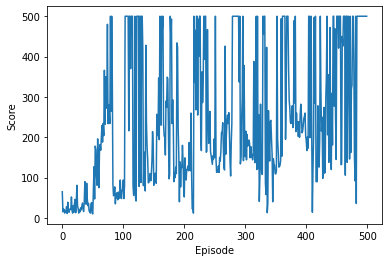

In [ ]:
# Cambios en hiperparámetros
K_TMODEL = 10
N = 5

MAX_STEPS = 750
NUMBER_OF_EPISODES = 500 # Bajados porque no hacen falta más parece
MEMORY_SIZE = 1000000

BATCH_SIZE = 32
LEARNING_RATE = 0.001

GAMMA = 0.99
EXPLORATION_MAX = 1
EXPLORATION_MIN = 0.005
EXPLORATION_DECAY = 0.9997 # Reducido el decay de exploration

environment, number_of_observations, number_of_actions = create_environment()

model = keras.models.Sequential()
model.add(keras.layers.Dense(96*4, input_shape=(number_of_observations,),
          activation="selu",kernel_initializer="lecun_normal"))
model.add(keras.layers.Dense(96*5, activation="selu",kernel_initializer="lecun_normal")) # Subimos cantidad de neuronas
model.add(keras.layers.Dense(48*2, activation="selu",kernel_initializer="lecun_normal"))
model.add(keras.layers.Dense(number_of_actions, activation="linear"))
model.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE))

# Lanzar modelo
agent = DQNTNetwork(number_of_observations, number_of_actions, model)
run(agent, environment)

Parece que el aprendizaje sigue siendo muy inestable